EE259 Project

Monet Painting

Rojin Zandi

Last Part

> ### Import libraries

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np
import re
import PIL
import os
import shutil

>### Configure TPU

In [15]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTO = tf.data.experimental.AUTOTUNE
print(tf.__version__)

Number of replicas: 1
2.4.1


>### Get image data from google cloud storage

In [ ]:
# Google Cloud Storage path for dataset
GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')

In [ ]:
# Size of input data
MONET_FILES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in MONET_FILES]
n_monet = np.sum(n)
n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in PHOTO_FILES]
n_photo = np.sum(n)

print(f'Monet image files: {n_monet}')
print(f'Photo image files: {n_photo}')

Monet image files: 300
Photo image files: 7038


>### Function to read image (tensorflow record)

In [ ]:
def read_tfrecord(example):# read image
    IMAGE_SIZE = [256, 256]
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    im = example['image']
    
    image = tf.image.decode_jpeg(im, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    
    return image

>### Data Augmentation

In [ ]:
def augment_image(image): # input data augmentation
    x = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    y = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if y > .5: # random crop image
        image = tf.image.resize(image, [286, 286])
        image = tf.image.random_crop(image, size=[256, 256, 3])
            
    if x > .6: # random flip image
        image = tf.image.random_flip_left_right(image)
    
    return image

>### Load Dataset

In [ ]:
# Function to load dataset
def load_data(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):
    monet_ds = load_data(monet_files)
    photo_ds = load_data(photo_files)
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO)
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
#     if shuffle:
#         monet_ds = monet_ds.shuffle(2048)
#         photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
#     monet_ds = monet_ds.cache()
#     photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO)
    photo_ds = photo_ds.prefetch(AUTO)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

# Load dataset
data = gan_dataset(MONET_FILES, PHOTO_FILES, augment=augment_image, repeat=True, shuffle=True, batch_size=4)

>### Data Visualization

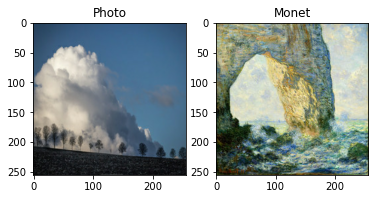

In [ ]:
sample_monet , sample_photo = next(iter(data))

# Display Photo images
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

# Display Monet images
plt.subplot(122)
plt.title('Monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

In [ ]:
import math
import cv2
def batch_visualization(path, n_images, is_random=True, figsize=(16, 16)):
    plt.figure(figsize=figsize)
    
    w = int(n_images ** .5)
    h = math.ceil(n_images / w)
    
    all_names = os.listdir(path)
    
    image_names = all_names[:n_images]
    if is_random:
        image_names = random.sample(all_names, n_images)
    
    for ind, image_name in enumerate(image_names):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.show()

In [ ]:
import os
import math
import random
BASE_PATH = "../input/gan-getting-started/"
MONET_PATH = os.path.join(BASE_PATH, "monet_jpg")
PHOTO_PATH = os.path.join(BASE_PATH, "photo_jpg")

In [ ]:
def color_hist_visualization(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis("off")
    
    colors = ["red", "green", "blue"]
    for i in range(len(colors)):
        plt.subplot(1, 4, i + 2)
        plt.hist(
            img[:, :, i].reshape(-1),
            bins=25,
            alpha=0.5,
            color=colors[i],
            density=True
        )
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
    
    
    plt.show()

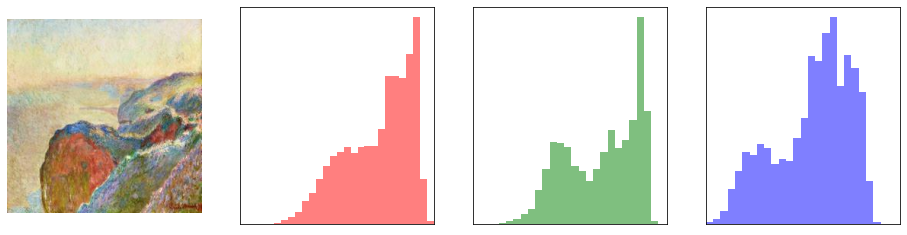

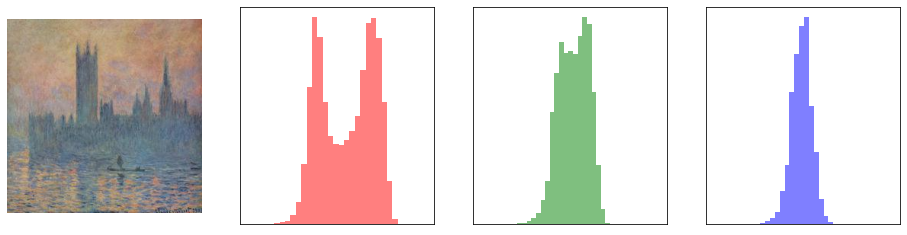

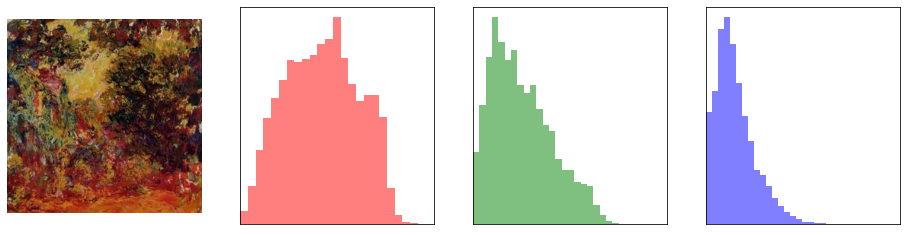

In [ ]:
img_path = '../input/gan-getting-started/monet_jpg/000c1e3bff.jpg'
color_hist_visualization(img_path)

img_path = '../input/gan-getting-started/monet_jpg/05144e306f.jpg'
color_hist_visualization(img_path)

img_path = '../input/gan-getting-started/monet_jpg/16dabe418c.jpg'
color_hist_visualization(img_path)

In [ ]:
def channels_visualization(image_path, figsize=(16, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 4, 1)
    plt.imshow(np.mean(img, axis=2), cmap="gray")
    plt.axis('off')
    
    for i in range(3):
        plt.subplot(1, 4, i + 2)
        tmp_img = np.full_like(img, 0)
        tmp_img[:, :, i] = img[:, :, i]
        plt.imshow(tmp_img)
        plt.xlim(0, 255)
        plt.xticks([])
        plt.yticks([])
    
    
    plt.show()

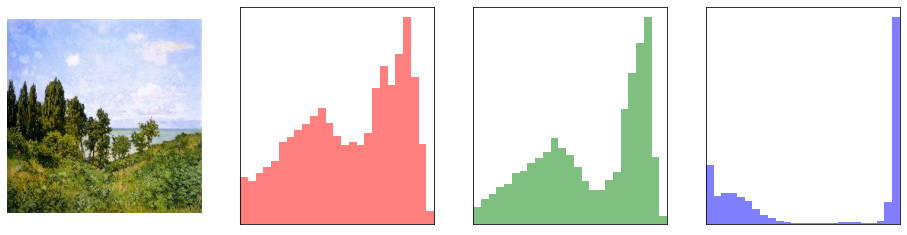

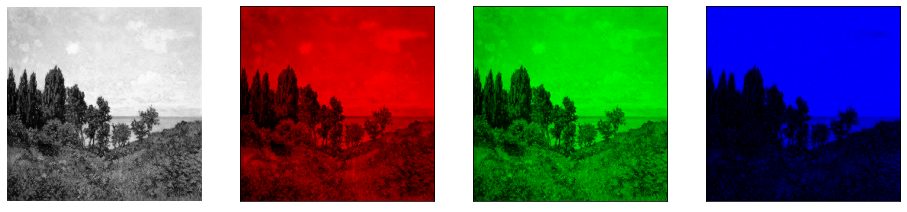

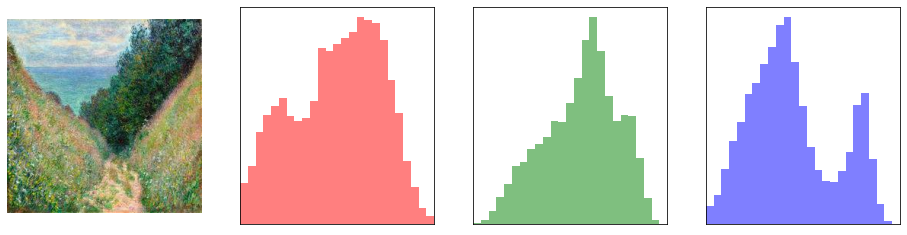

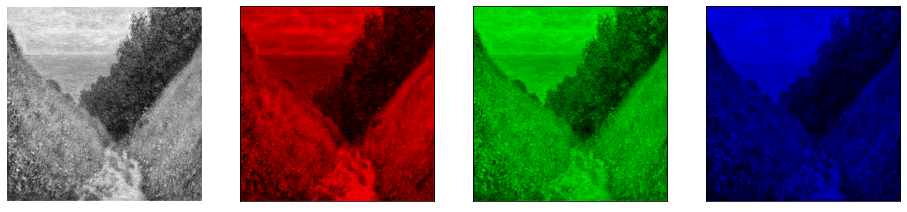

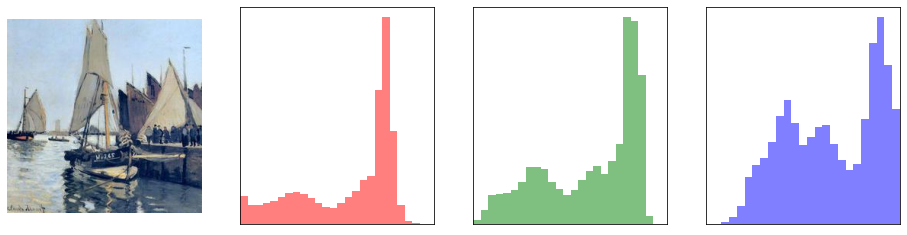

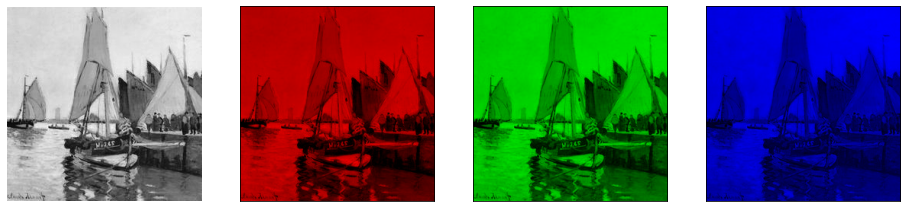

In [ ]:
img_path = '../input/gan-getting-started/monet_jpg/51db3fc011.jpg'
color_hist_visualization(img_path)
channels_visualization(img_path)

img_path = '../input/gan-getting-started/monet_jpg/1814cc6632.jpg'
color_hist_visualization(img_path)
channels_visualization(img_path)

img_path = '../input/gan-getting-started/monet_jpg/4995c04b1a.jpg'
color_hist_visualization(img_path)
channels_visualization(img_path)

In [ ]:
def grayscale_visualization(image_path, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    tmp_img = np.full_like(img, 0)
    for i in range(3):
        tmp_img[:, :, i] = img.mean(axis=-1)
    plt.imshow(tmp_img)
    plt.axis('off')
    
    
    plt.show()

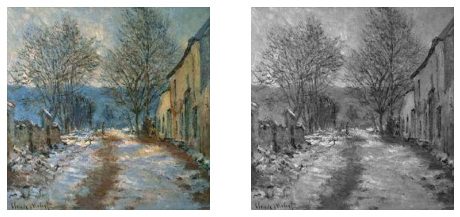

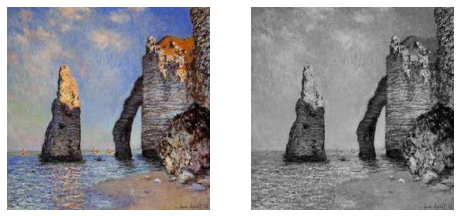

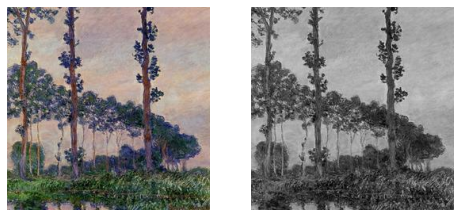

In [ ]:
img_path = '../input/gan-getting-started/monet_jpg/5c79cfe0b3.jpg'
grayscale_visualization(img_path)

img_path = '../input/gan-getting-started/monet_jpg/990ed28f62.jpg'
grayscale_visualization(img_path)

img_path = '../input/gan-getting-started/monet_jpg/fd63a333f1.jpg'
grayscale_visualization(img_path)

>### Building the Cycle GAN

Downsampling:

In [7]:
def down_sample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    layer.add(layers.LeakyReLU())

    return layer

Upsampling:

In [10]:
def up_sample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    layer = keras.Sequential()
    layer.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer,use_bias=False))
    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        layer.add(layers.Dropout(0.5))

    layer.add(layers.ReLU())

    return layer

In [11]:
def generator():
    inputs = layers.Input(shape=[256,256,3])
    down_stack = [
        down_sample(64, 4, apply_instancenorm=False),# (size, 128, 128, 64)
        down_sample(128, 4),                         # (size, 64, 64, 128)
        down_sample(256, 4),                         # (size, 32, 32, 256)
        down_sample(512, 4),                         # (size, 16, 16, 512)
        down_sample(512, 4),                         # (size, 8, 8, 512)
        down_sample(512, 4),                         # (size, 4, 4, 512)
        down_sample(512, 4),                         # (size, 2, 2, 512)
        down_sample(512, 4),                         # (size, 1, 1, 512)
    ]

    up_stack = [
        up_sample(512, 4, apply_dropout=True),       # (size, 2, 2, 1024)
        up_sample(512, 4, apply_dropout=True),       # (size, 4, 4, 1024)
        up_sample(512, 4, apply_dropout=True),       # (size, 8, 8, 1024)
        up_sample(512, 4),                           # (size, 16, 16, 1024)
        up_sample(256, 4),                           # (size, 32, 32, 512)
        up_sample(128, 4),                           # (size, 64, 64, 256)
        up_sample(64, 4),                            # (size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') 
    # (size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [12]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp
    
    down1 = down_sample(64, 4, False)(x)       # (size, 128, 128, 64)
    down2 = down_sample(128, 4)(down1)         # (size, 64, 64, 128)
    down3 = down_sample(256, 4)(down2)         # (size, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (size, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (size, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (size, 33, 33, 512)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (size, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [13]:
class Gan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=150,
    ):
        super(Gan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(Gan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
#             cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
#             fake_photo = self.p_gen(real_monet, training=True)
#             cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
#             same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
#             disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
#             disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
#             photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
#             total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
#             total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
#             photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
#         photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
#         photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
#         self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
#         self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
#             "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
#             "photo_disc_loss": photo_disc_loss
        }

>### Generate images and send to discriminator

In [20]:
with strategy.scope(): # for TPU
    monet_generator = generator() # transforms photos to Monet paintings
    photo_generator = generator() # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator() # differentiates real photos and generated photos


>### Print sample generated image

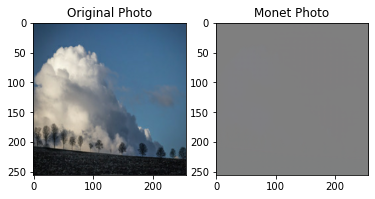

In [ ]:
to_monet = monet_generator(sample_photo) # sample run monet generator

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(sample_photo[0] * 0.5 + 0.5) # input photo

plt.subplot(1, 2, 2)
plt.title("Monet Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5) # output monet
plt.show()

>### Generator and discriminator loss functions

In [21]:
with strategy.scope(): # for TPU
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [22]:
with strategy.scope(): # for TPU
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [23]:
with strategy.scope(): # for TPU
    def calculate_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [24]:
with strategy.scope(): # for TPU
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

>### Compile GAN

In [25]:
with strategy.scope(): # for TPU
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [26]:
with strategy.scope(): # for TPU
    gan_model = Gan(monet_generator, photo_generator, monet_discriminator, photo_discriminator)

    gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calculate_cycle_loss,
        identity_loss_fn = identity_loss
    )

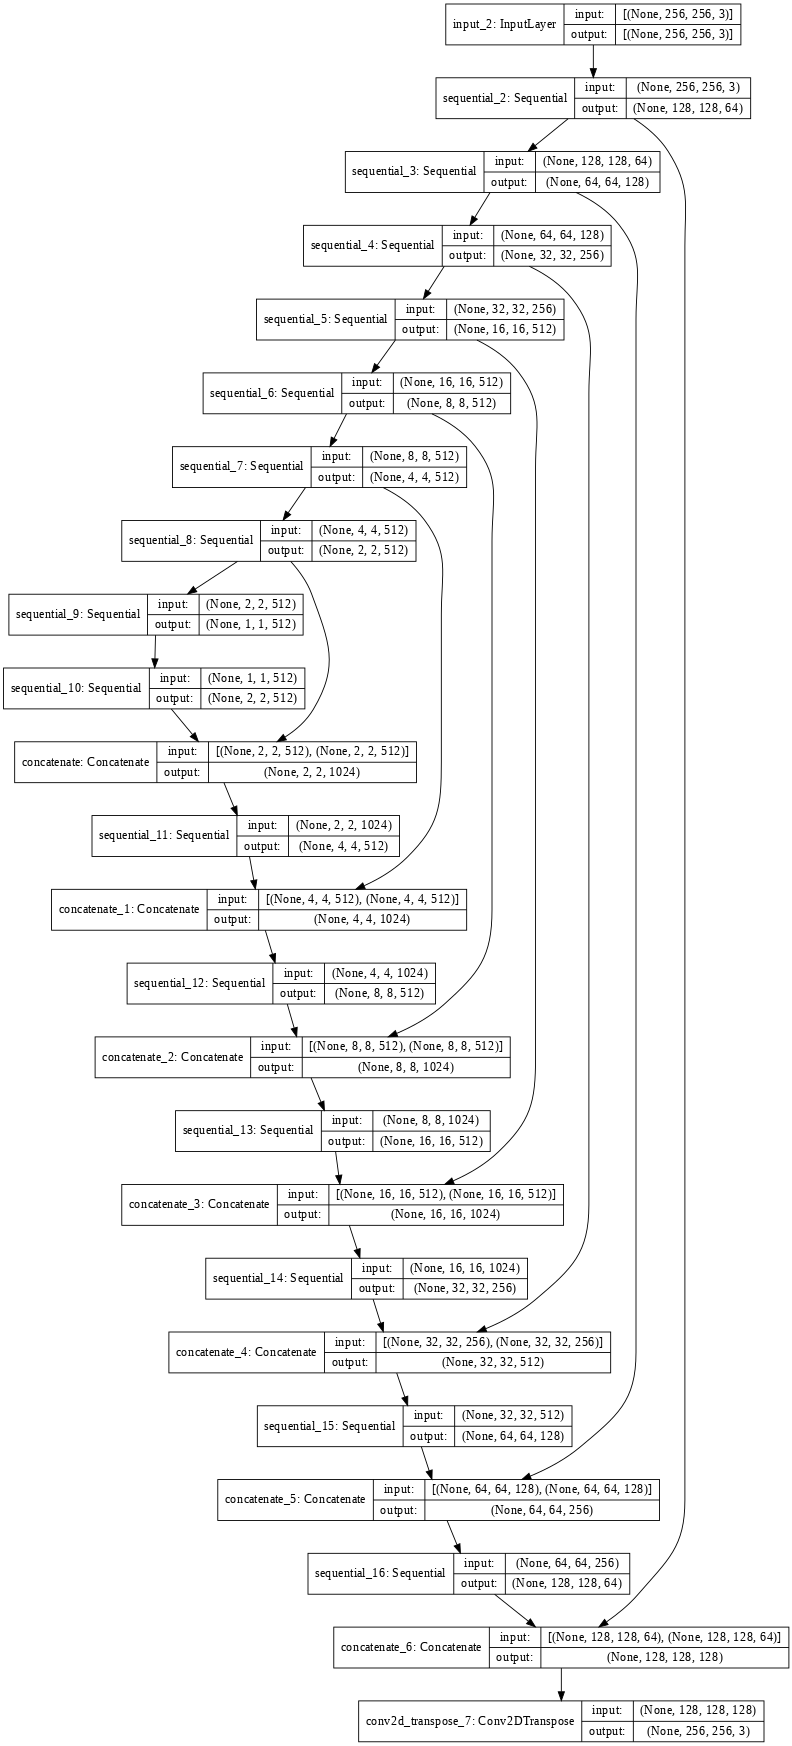

In [33]:
tf.keras.utils.plot_model(monet_generator, show_shapes=True, dpi=64, to_file="Monet Generator.png")

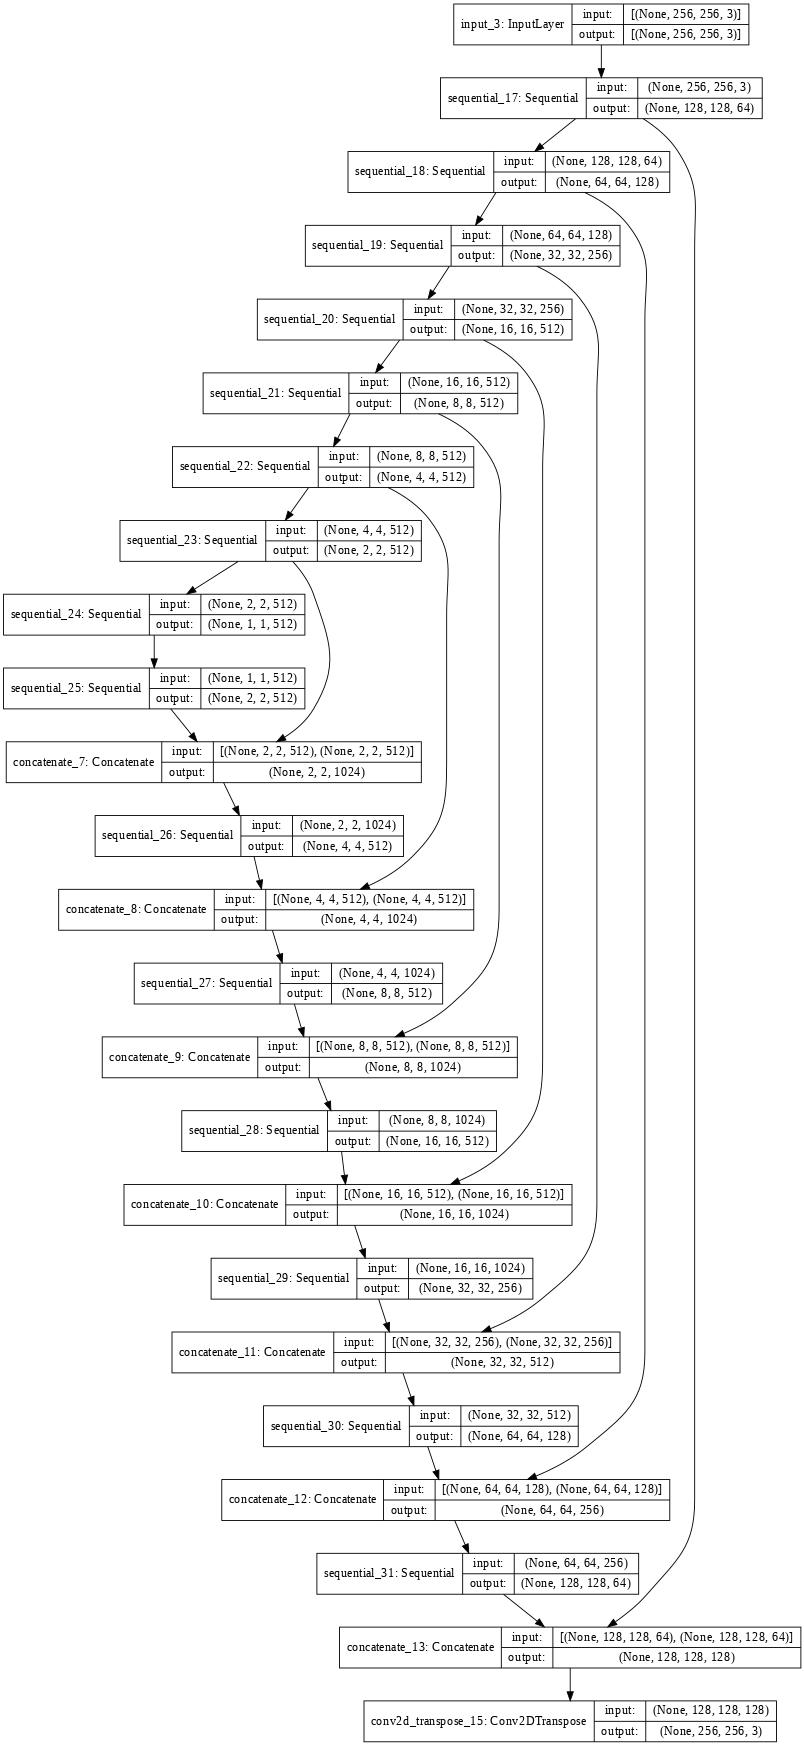

In [34]:
tf.keras.utils.plot_model(photo_generator, show_shapes=True, dpi=64, to_file="Photo Generator.png")

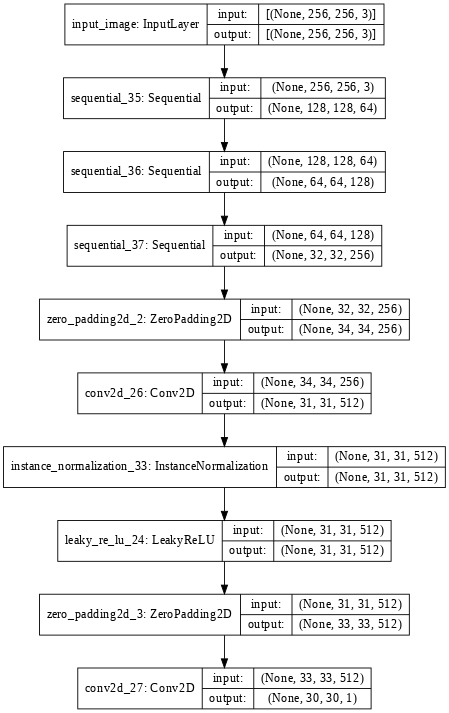

In [32]:
tf.keras.utils.plot_model(photo_discriminator, show_shapes=True, dpi=64, to_file="Photo Discriminator.png")

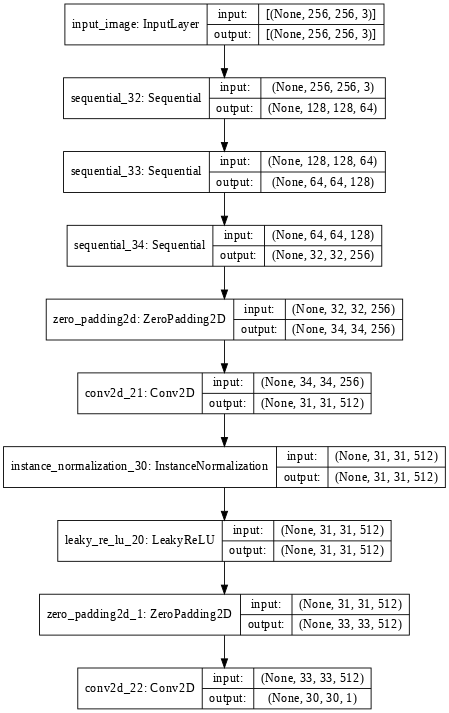

In [31]:
tf.keras.utils.plot_model(monet_discriminator, show_shapes=True, dpi=64, to_file="Monet Discriminator.png")

In [ ]:
gan_model.fit(data, epochs=30, steps_per_epoch=(max(n_monet, n_photo)//5))

Epoch 1/30
1407/1407 [==============================] - 258s 183ms/step - monet_gen_loss: 6.3689 - monet_disc_loss: 0.5611
Epoch 2/30
1407/1407 [==============================] - 256s 182ms/step - monet_gen_loss: 4.1571 - monet_disc_loss: 0.5472
Epoch 3/30
1407/1407 [==============================] - 256s 182ms/step - monet_gen_loss: 3.6625 - monet_disc_loss: 0.5583
Epoch 4/30
1407/1407 [==============================] - 257s 183ms/step - monet_gen_loss: 3.3670 - monet_disc_loss: 0.5704
Epoch 5/30
1407/1407 [==============================] - 257s 183ms/step - monet_gen_loss: 3.1403 - monet_disc_loss: 0.5896
Epoch 6/30
1407/1407 [==============================] - 257s 182ms/step - monet_gen_loss: 3.0688 - monet_disc_loss: 0.5874
Epoch 7/30
1407/1407 [==============================] - 257s 182ms/step - monet_gen_loss: 2.9086 - monet_disc_loss: 0.5985
Epoch 8/30
1407/1407 [==============================] - 256s 182ms/step - monet_gen_loss: 2.8478 - monet_disc_loss: 0.5923
Epoch 9/30
1407/

>### Generate and save the ouput

In [ ]:
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [ ]:
os.makedirs('../images/')
predict_and_save(load_data(PHOTO_FILES).batch(1), monet_generator, '../images/')
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')
print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Generated samples: 7038
